In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
import config.config_evaluation as config
import matplotlib.pyplot as plt
import time as t

%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Temp fix
def calc_effort_d(f_task, pos, pos_d, vel):
    result = np.array(f_task)
    
    K = np.diag(np.array([400, 400, 1080, 50, 50, 50]))
    D = 2 * np.sqrt(K)
    
    result = result - K.dot(np.array(pos_d) - np.array(pos))
    result = result + D.dot(np.array(vel))
        
    return result.tolist()
    

start_time = t.time()
print("Reading data files")

pose_data = []
pose_d_data = []
velocity_data = []
effort_data = []
effort_d_data = []

for i in range(len(config.executions)):
    filename = config.executions[i]
    print(f'Reading data file {filename}')
    
    pose_data.append(PoseDataSet())
    pose_d_data.append(PoseDataSet())
    velocity_data.append(PoseDataSet())
    effort_data.append(PoseDataSet())
    effort_d_data.append(PoseDataSet())
    
    reader = ImpactControlStateReader(filename)
    
    while not reader.end():
        dp = reader.next_datapoint()
        time = dp.time
        state = dp.value
        
        pose_data[i].append(PoseDataPoint(time, state.position + state.euler_angles))
        pose_d_data[i].append(PoseDataPoint(time, state.position_desired + state.euler_angles_desired))
        velocity_data[i].append(PoseDataPoint(time, state.velocity + state.rotational_velocity))
        effort_data[i].append(PoseDataPoint(time, state.force_external + state.torque_external))
        # Temp fix
#         effort_d_data[i].append(PoseDataPoint(time, calc_effort_d(state.force_task + state.torque_task, state.position + state.euler_angles, state.position_desired + state.euler_angles_desired, state.velocity + state.rotational_velocity)))
        effort_d_data[i].append(PoseDataPoint(time, state.effort_desired if state.control_options.use_effort_feedforward else [0,0,0,0,0,0]))
    
    pose_data[i].align_time()
    pose_d_data[i].align_time()
    velocity_data[i].align_time()
    effort_data[i].align_time()
    effort_d_data[i].align_time()
    
    print(f'Average sampling frequency of {config.executions[i]} is {(len(pose_data[i]) - 1) / (pose_data[i].time[-1] - pose_data[i].time[0])} Hz')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading data files
Reading data file data/replay8.bag
Average sampling frequency of data/replay8.bag is 995.1936835498082 Hz
Reading data file data/replay9.bag
Average sampling frequency of data/replay9.bag is 994.8669996178529 Hz
--- 55.15508055686951 seconds ---
Done


In [3]:
pose_diff_data = []
effort_diff_data = []

for i in range(len(pose_data)):
    pose_diff_data.append(pose_d_data[i] - pose_data[i])
    effort_diff_data.append(effort_d_data[i] - effort_data[i])

<IPython.core.display.Javascript object>


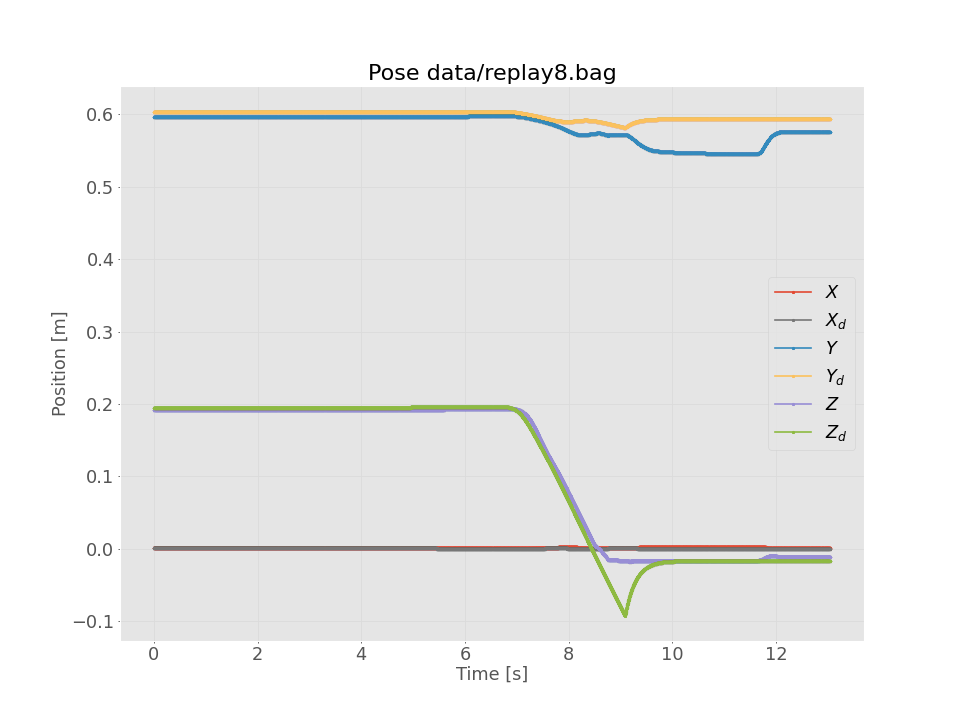

<IPython.core.display.Javascript object>


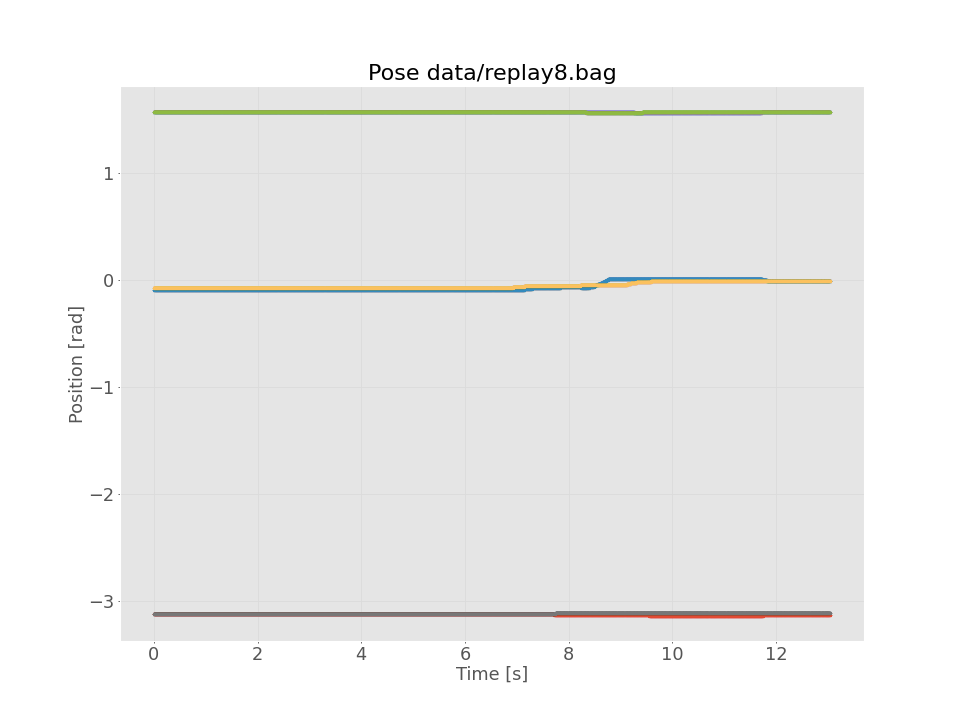

<IPython.core.display.Javascript object>


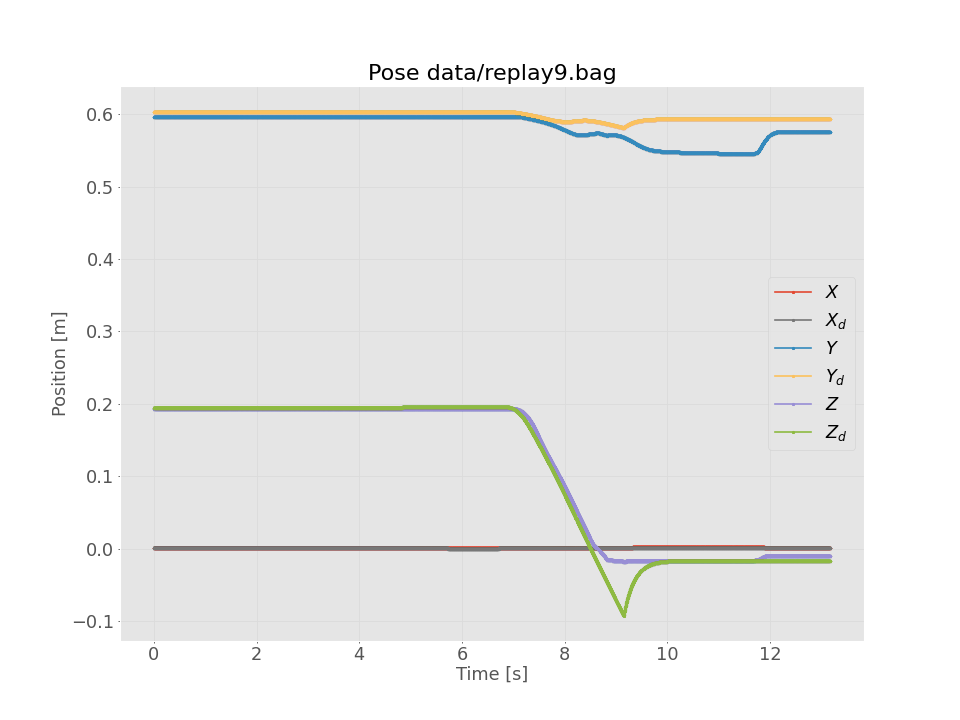

<IPython.core.display.Javascript object>


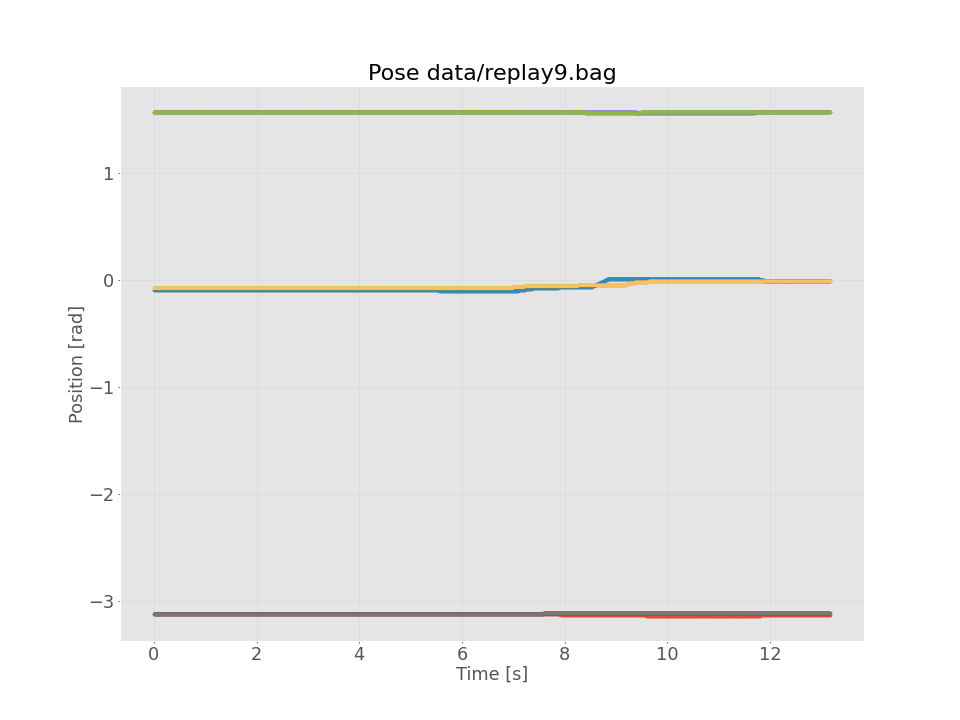

In [4]:
# Plotting pose diff data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = pose_data[i]
    data_d = pose_d_data[i]
    
    for k in range(2):
        fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2

        # Pose diff data
        for j in range(3):
            index = 3*k+j
            plt.plot(data.time, data.get_index(index).value, f'C{j}-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'${config.labels[index]}$')
            plt.plot(data_d.time, data_d.get_index(index).value, f'C{j+3}-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'${config.labels[index]}_d$')
            
        # Adding title and labels
        plt.title('Pose ' + filename,fontsize=config.fontsize1)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        if k == 0:
            plt.ylabel('Position [m]',fontsize=config.fontsize2)
        else:
            plt.ylabel('Position [rad]',fontsize=config.fontsize2)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)

<IPython.core.display.Javascript object>


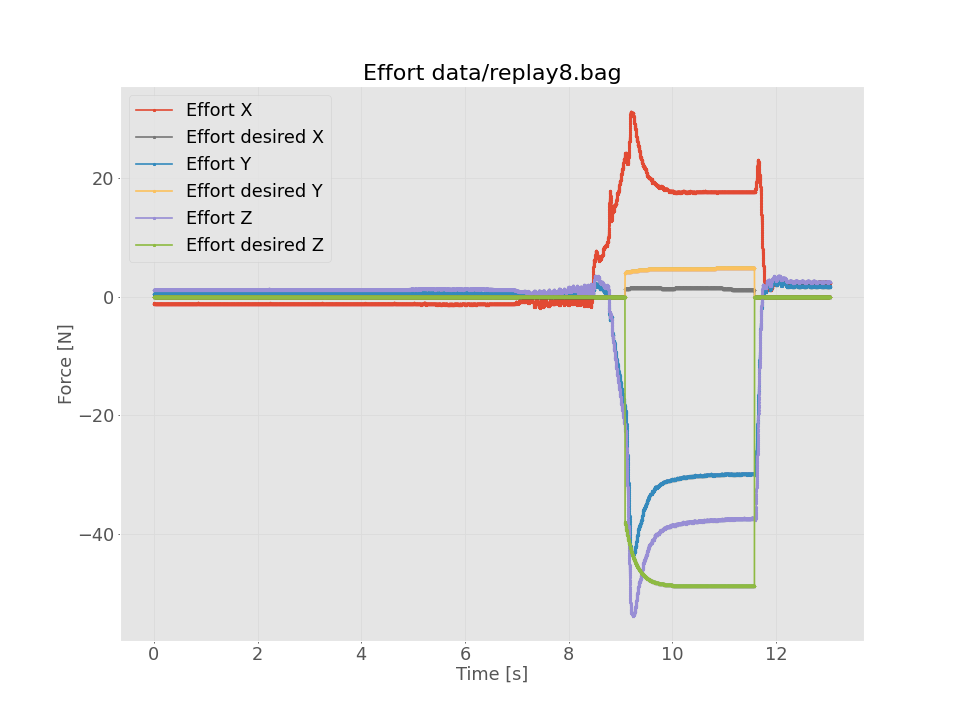

<IPython.core.display.Javascript object>


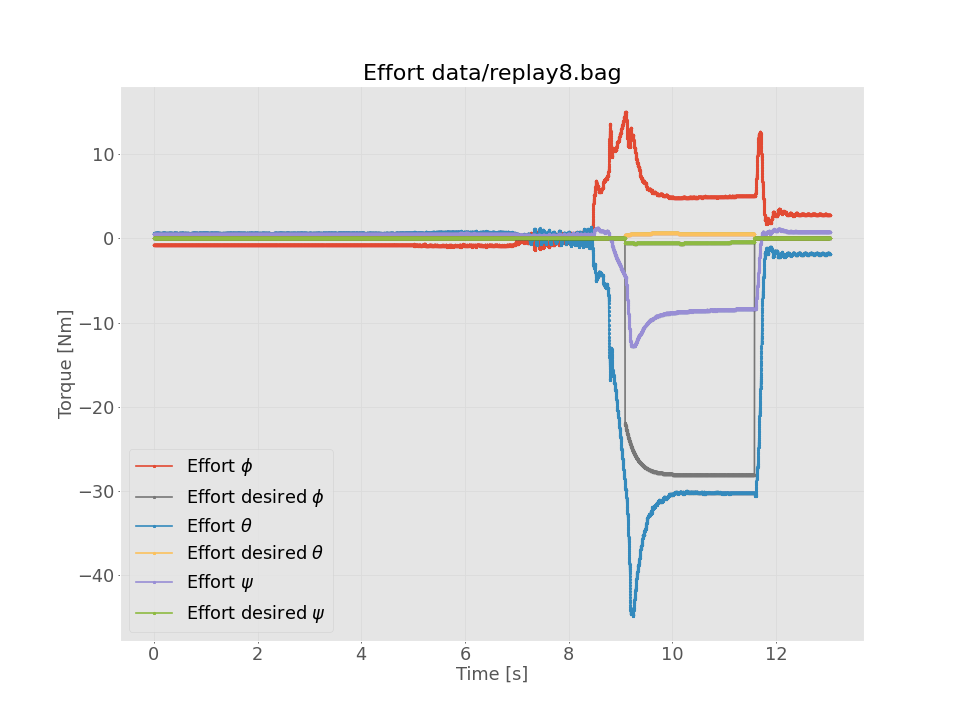

<IPython.core.display.Javascript object>


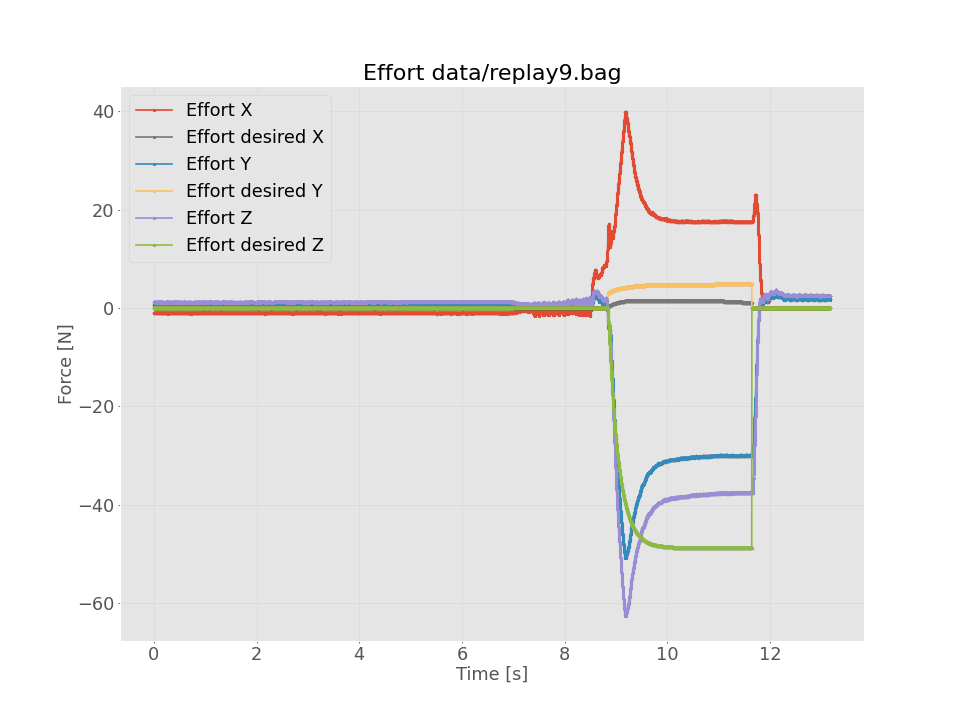

<IPython.core.display.Javascript object>


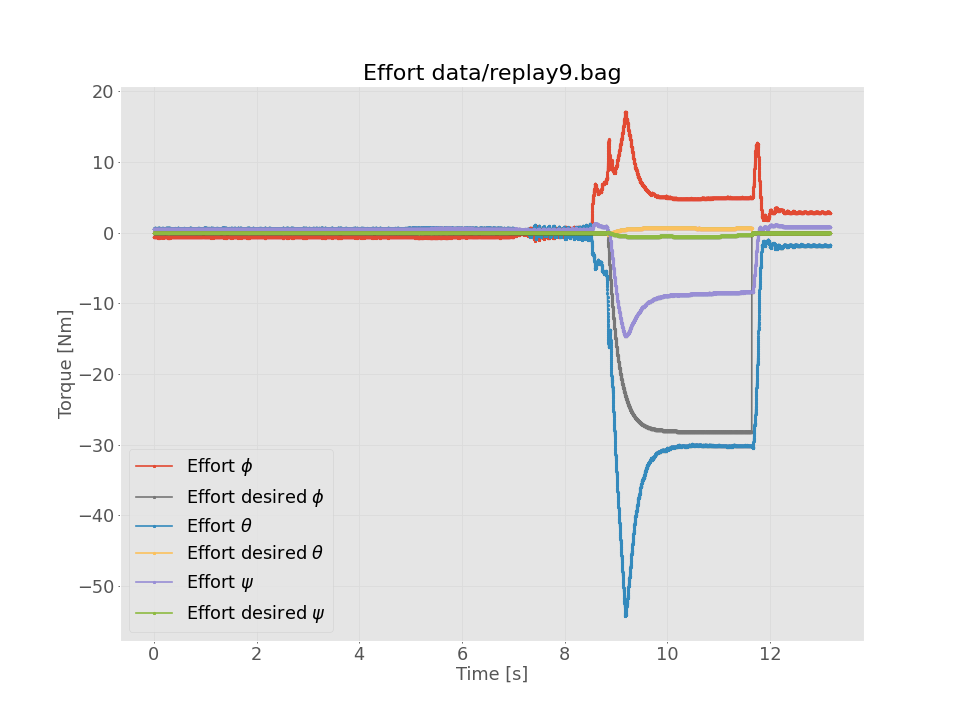

In [5]:
# Plotting effort diff data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = effort_data[i]
    data_d = effort_d_data[i]
    
    for k in range(2):
        fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2

        # Pose diff data
        for j in range(3):
            index = 3*k+j
            plt.plot(data.time, data.get_index(index).value, f'C{j}-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'Effort {config.labels[index]}')
            plt.plot(data_d.time, data_d.get_index(index).value, f'C{j+3}-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'Effort desired {config.labels[index]}')

            
        # Adding title and labels
        plt.title('Effort ' + filename,fontsize=config.fontsize1)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        if k == 0:
            plt.ylabel('Force [N]',fontsize=config.fontsize2)
        else:
            plt.ylabel('Torque [Nm]',fontsize=config.fontsize2)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)